In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [5]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

Client Scheduler: tcp://127.0.0.1:41198 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 28 Cores: 56 Memory: 404.32 GB


In [84]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

23-May-21 15:49:15 Loading position info...
23-May-21 15:50:08 Loading multiunit...
23-May-21 15:50:43 Loading spikes...
23-May-21 15:52:17 Finding ripple times...


In [115]:
from src.parameters import SAMPLING_FREQUENCY

is_pyramidal = np.asarray((data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY) < 5)

data['spikes'] = data['spikes'].loc[:, is_pyramidal]
data['neuron_info'] = data['neuron_info'].loc[is_pyramidal]

In [8]:
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'knot_spacing': 8,
    'spike_model_penalty': 0.5,
}

In [ ]:
from replay_trajectory_classification import SortedSpikesClassifier
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING, PROCESSED_DATA_DIR

from sklearn.model_selection import KFold
import os

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = SortedSpikesClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        spikes=data["spikes"].iloc[train],
        track_graph=data["track_graph"],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING,
    )
    classifier.save_model(
        os.path.join(PROCESSED_DATA_DIR,
            f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_"
            f"sortedspikes_no_interneuron_fold{fold_ind}_model.pkl")
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["spikes"].iloc[test],
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate results 
results = xr.concat(
    results, dim="time"
)

# save the results as .nc format. ncread matlab can read these
results.to_netcdf(
    os.path.join(PROCESSED_DATA_DIR,
   f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_sortedspikes_no_interneuron_results.nc")
)
logging.info('Done...\n\n')

22-May-21 11:06:33 Fitting Fold #1...
22-May-21 11:06:34 Fitting initial conditions...
22-May-21 11:06:35 Fitting state transition...
22-May-21 11:06:35 Fitting place fields...
22-May-21 11:14:46 Predicting posterior...


In [ ]:
client.close()

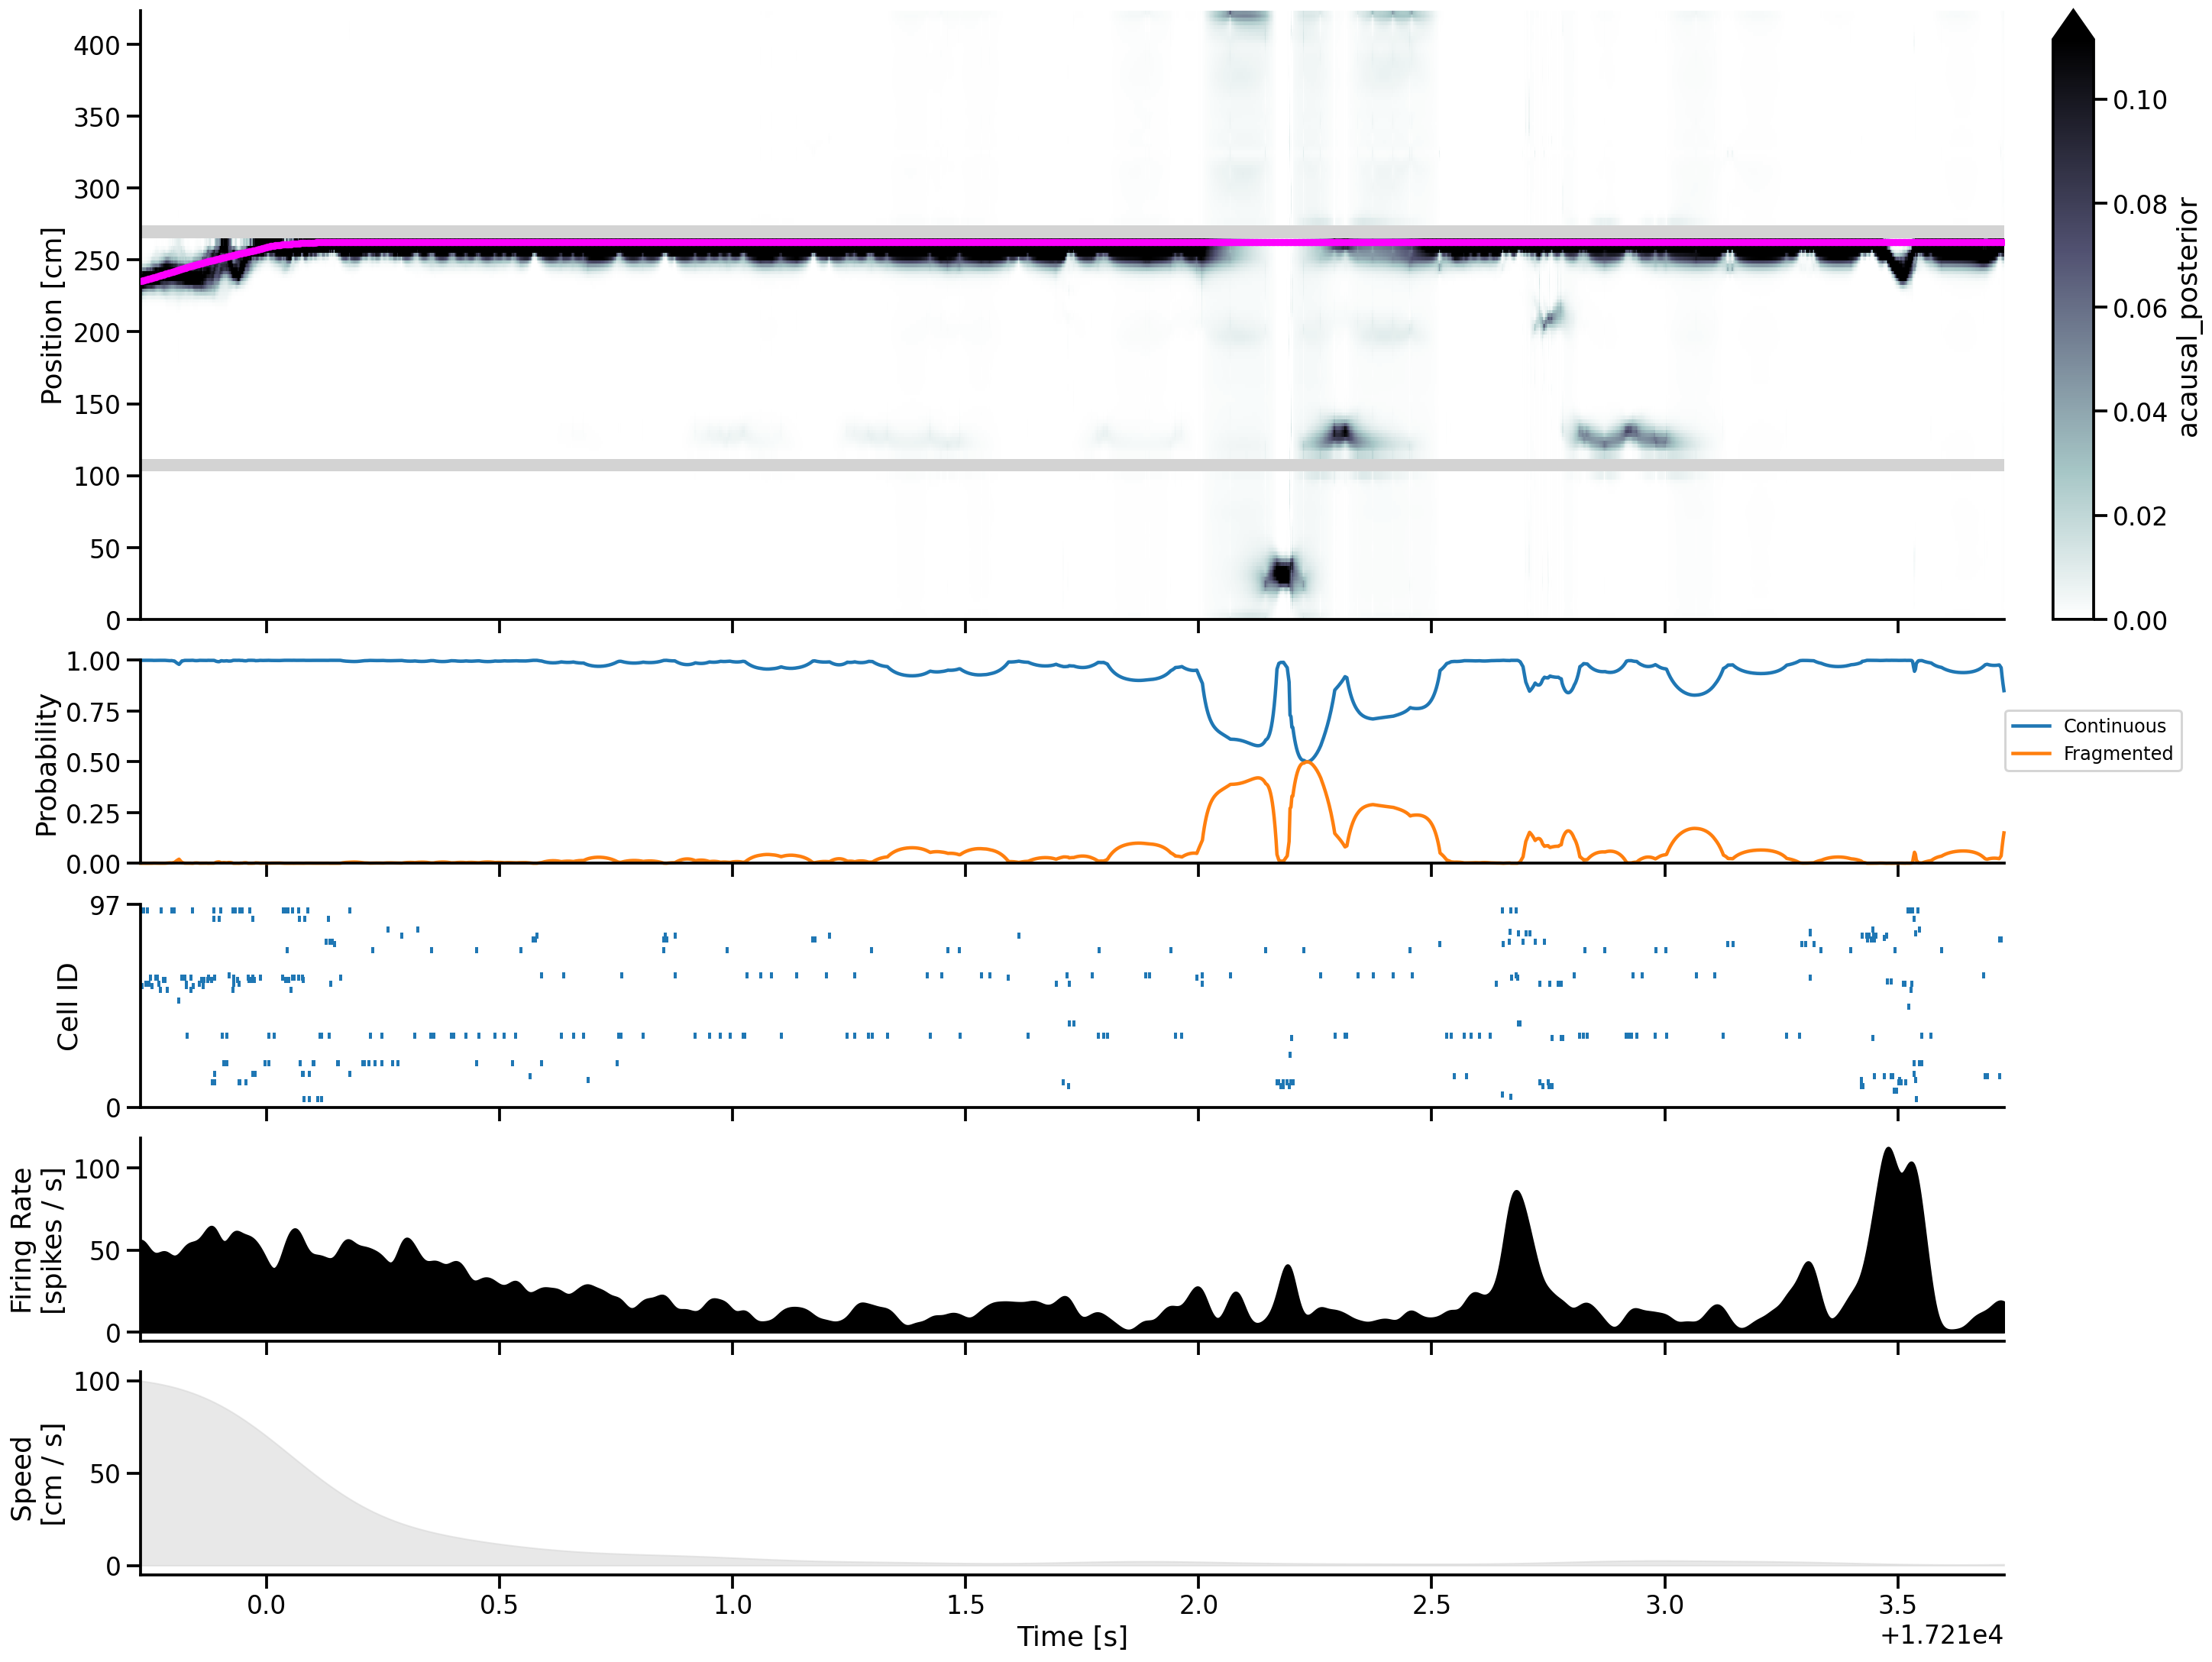

In [18]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(424_000, 426_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

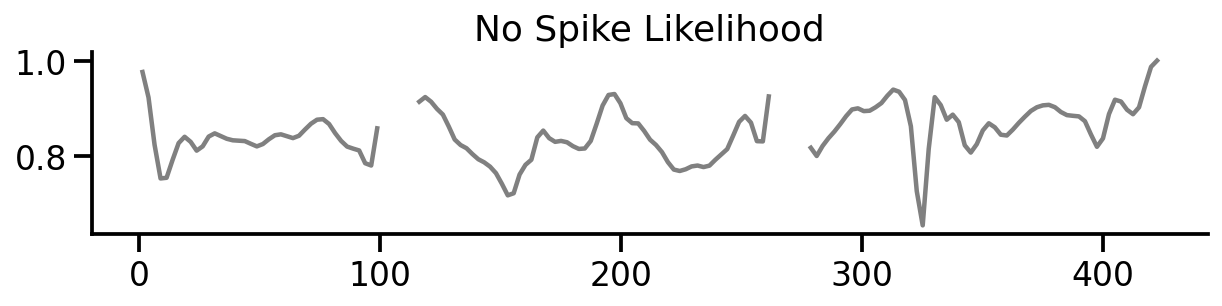

In [19]:
from replay_trajectory_classification.spiking_likelihood import estimate_spiking_likelihood
from replay_trajectory_classification.core import scaled_likelihood

n_neurons = data['spikes'].shape[1]
no_spike_likelihood = scaled_likelihood(estimate_spiking_likelihood(
    spikes=np.zeros((1, n_neurons)),
    conditional_intensity=np.asarray(classifier.place_fields_.sel(encoding_group=0)),
    is_track_interior=classifier.is_track_interior_), axis=-1).squeeze()

no_spike_likelihood[~classifier.is_track_interior_] = np.nan

plt.figure(figsize=(10, 5 / 3))
plt.plot(classifier.place_bin_centers_, no_spike_likelihood, color='grey')
plt.title('No Spike Likelihood')
sns.despine()

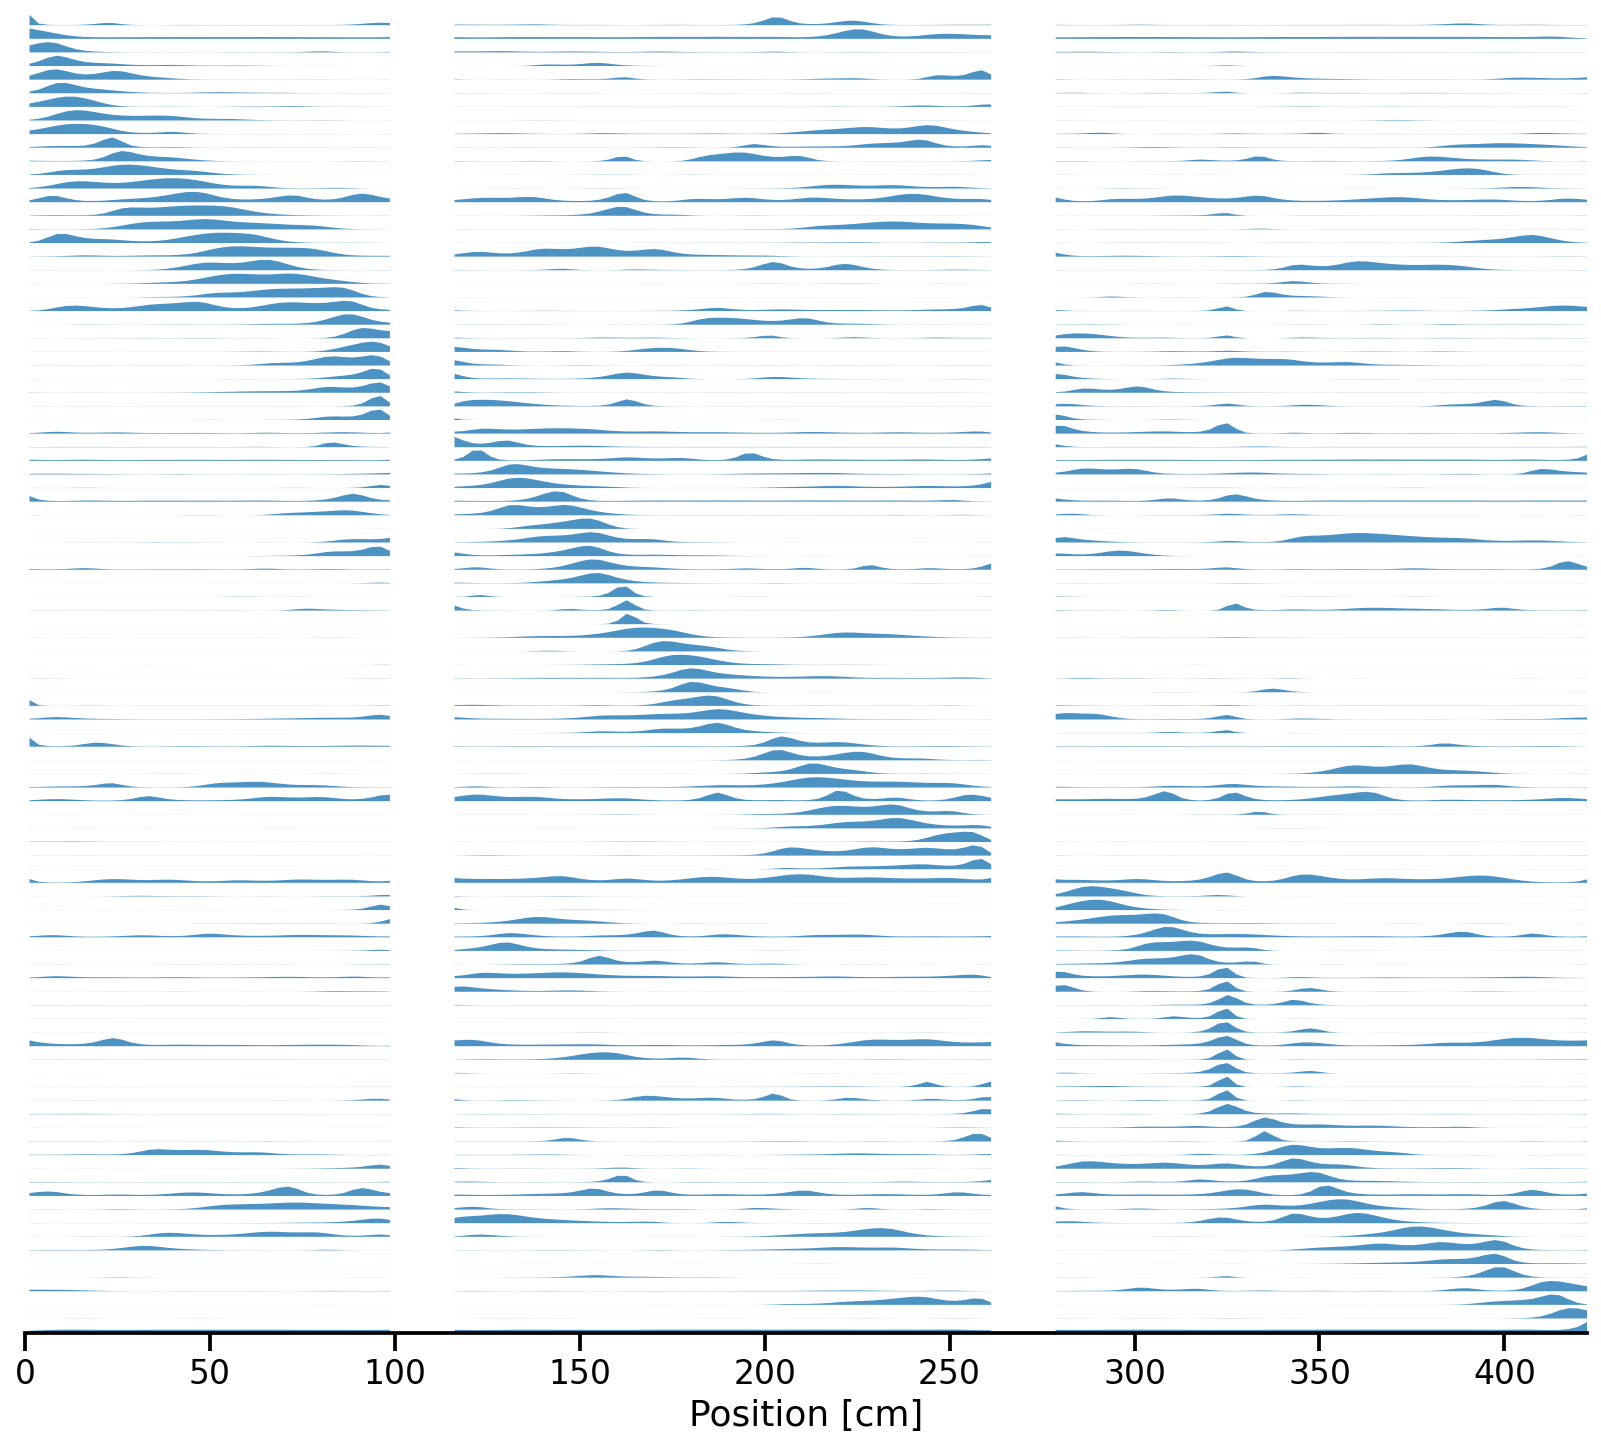

In [20]:
from src.visualization import plot_place_fields


plot_place_fields(classifier, sampling_frequency=500)

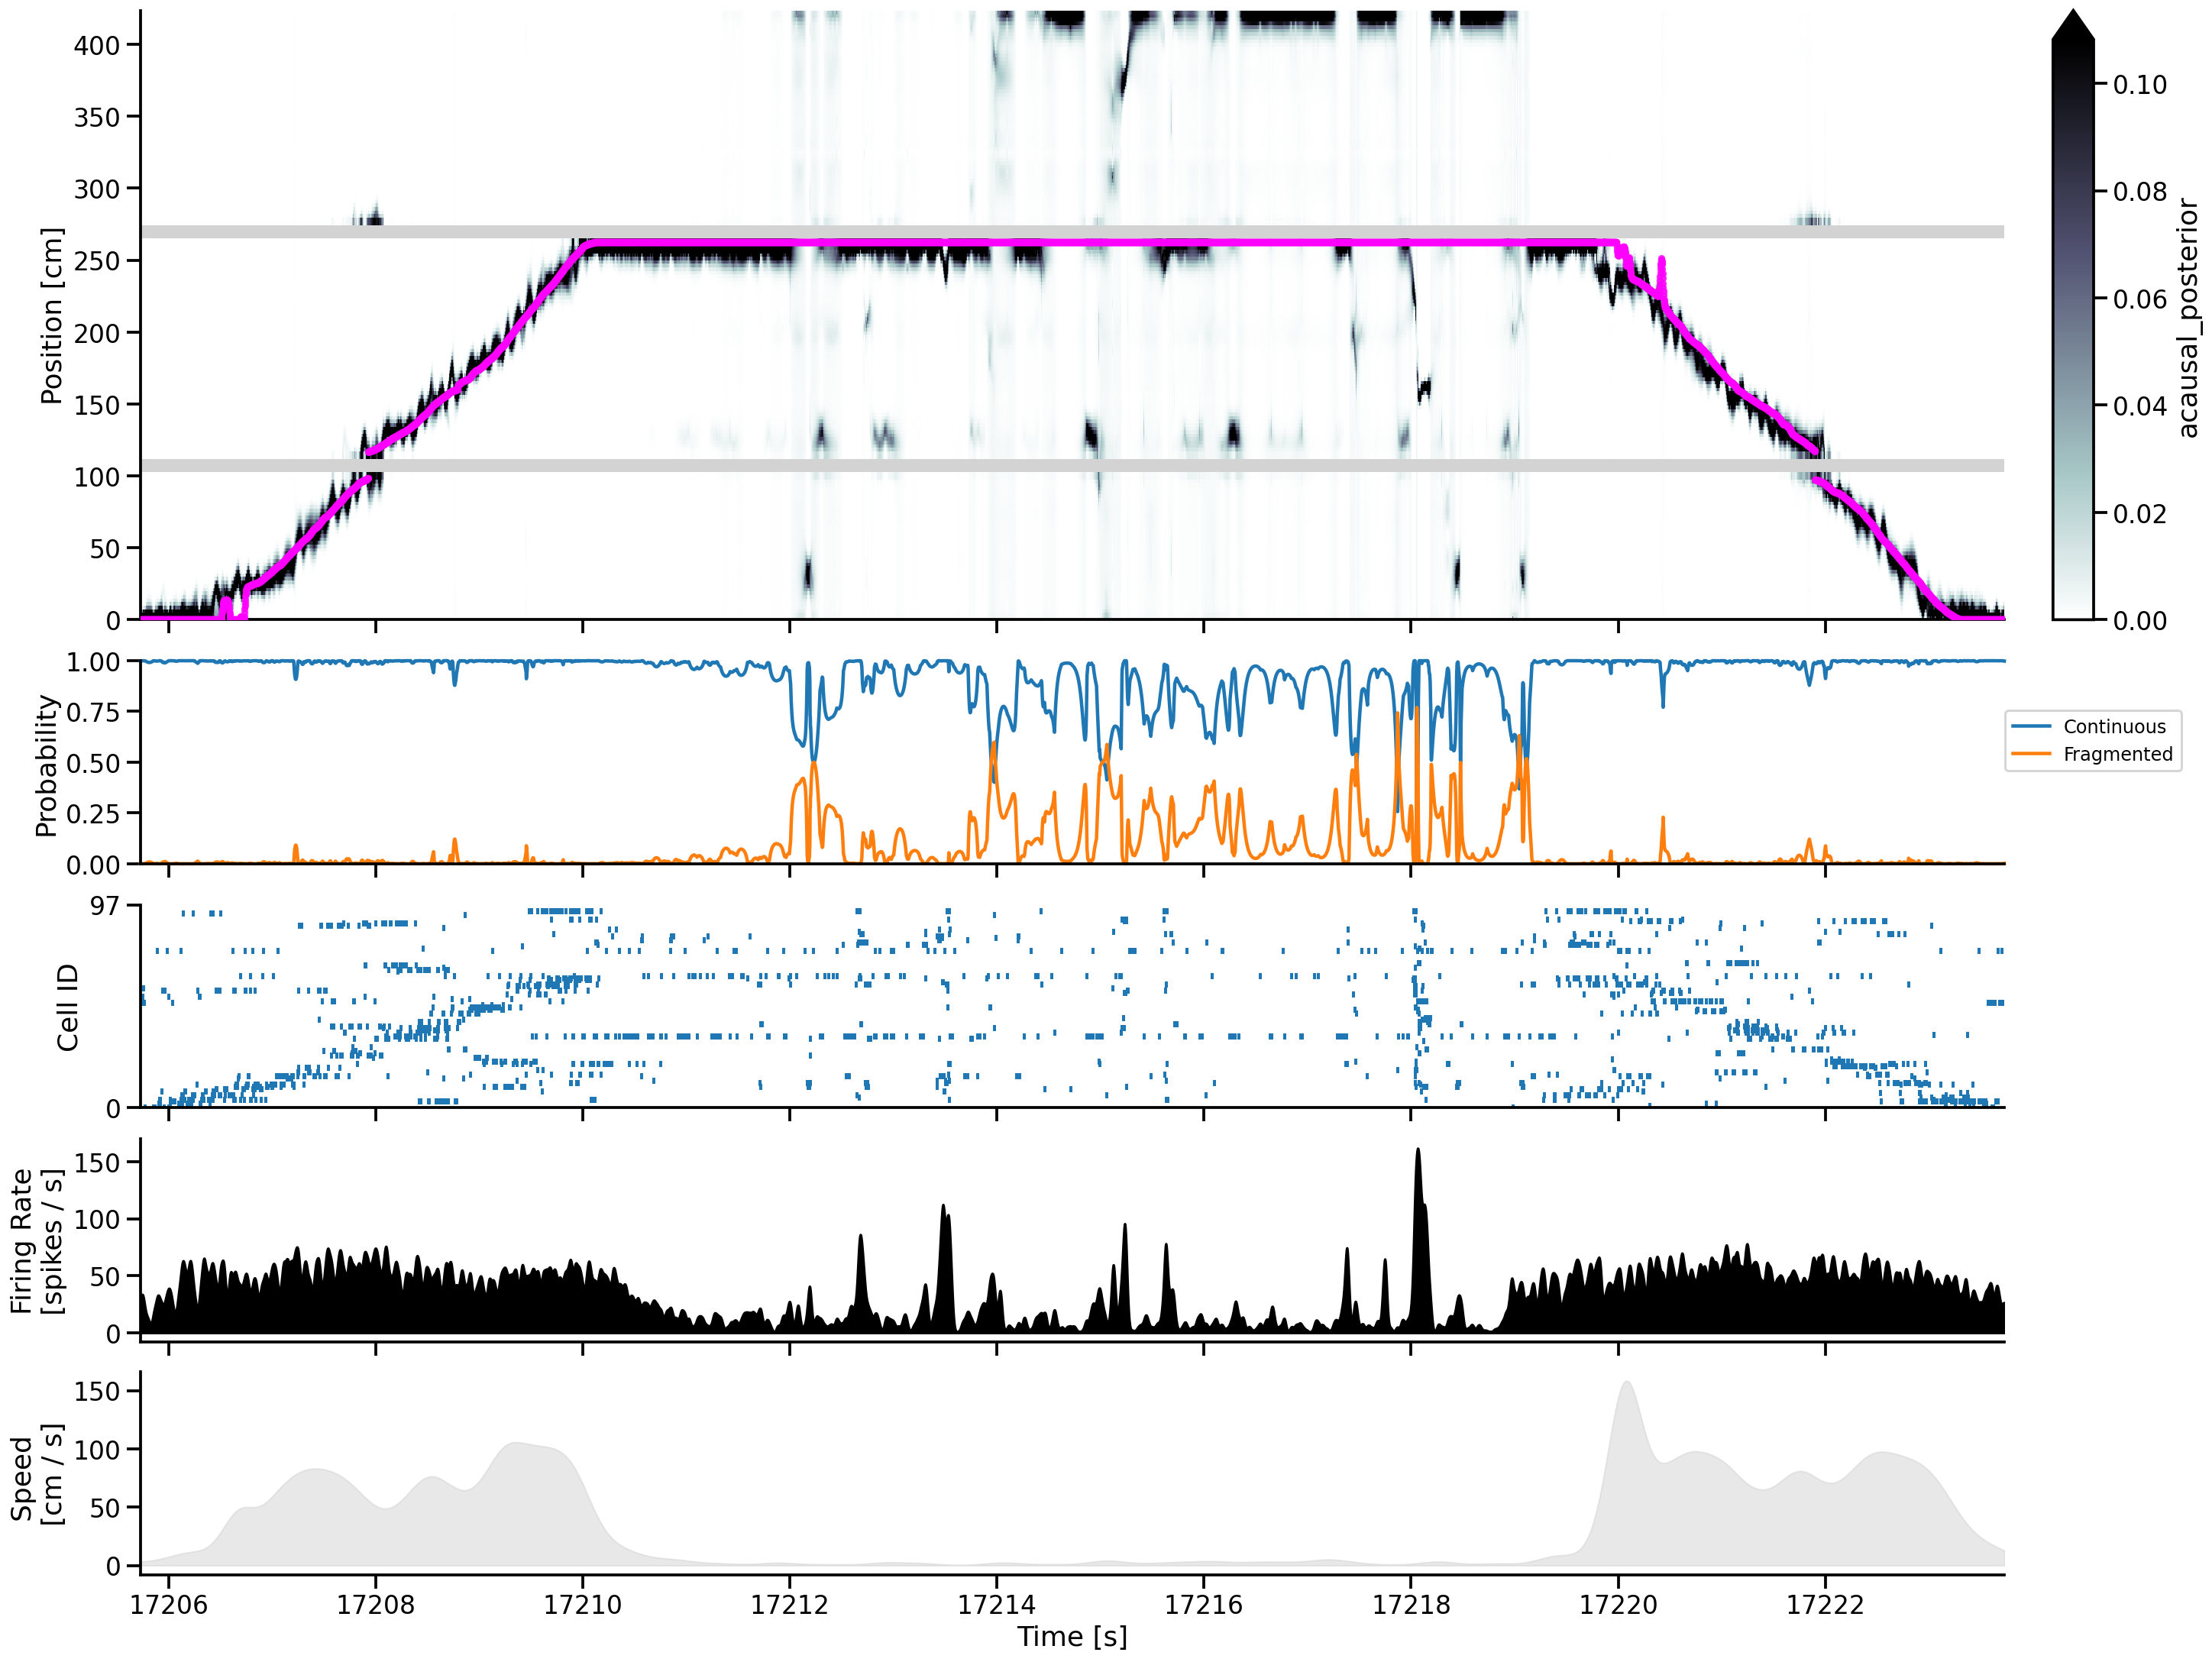

In [21]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(422_000, 431_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

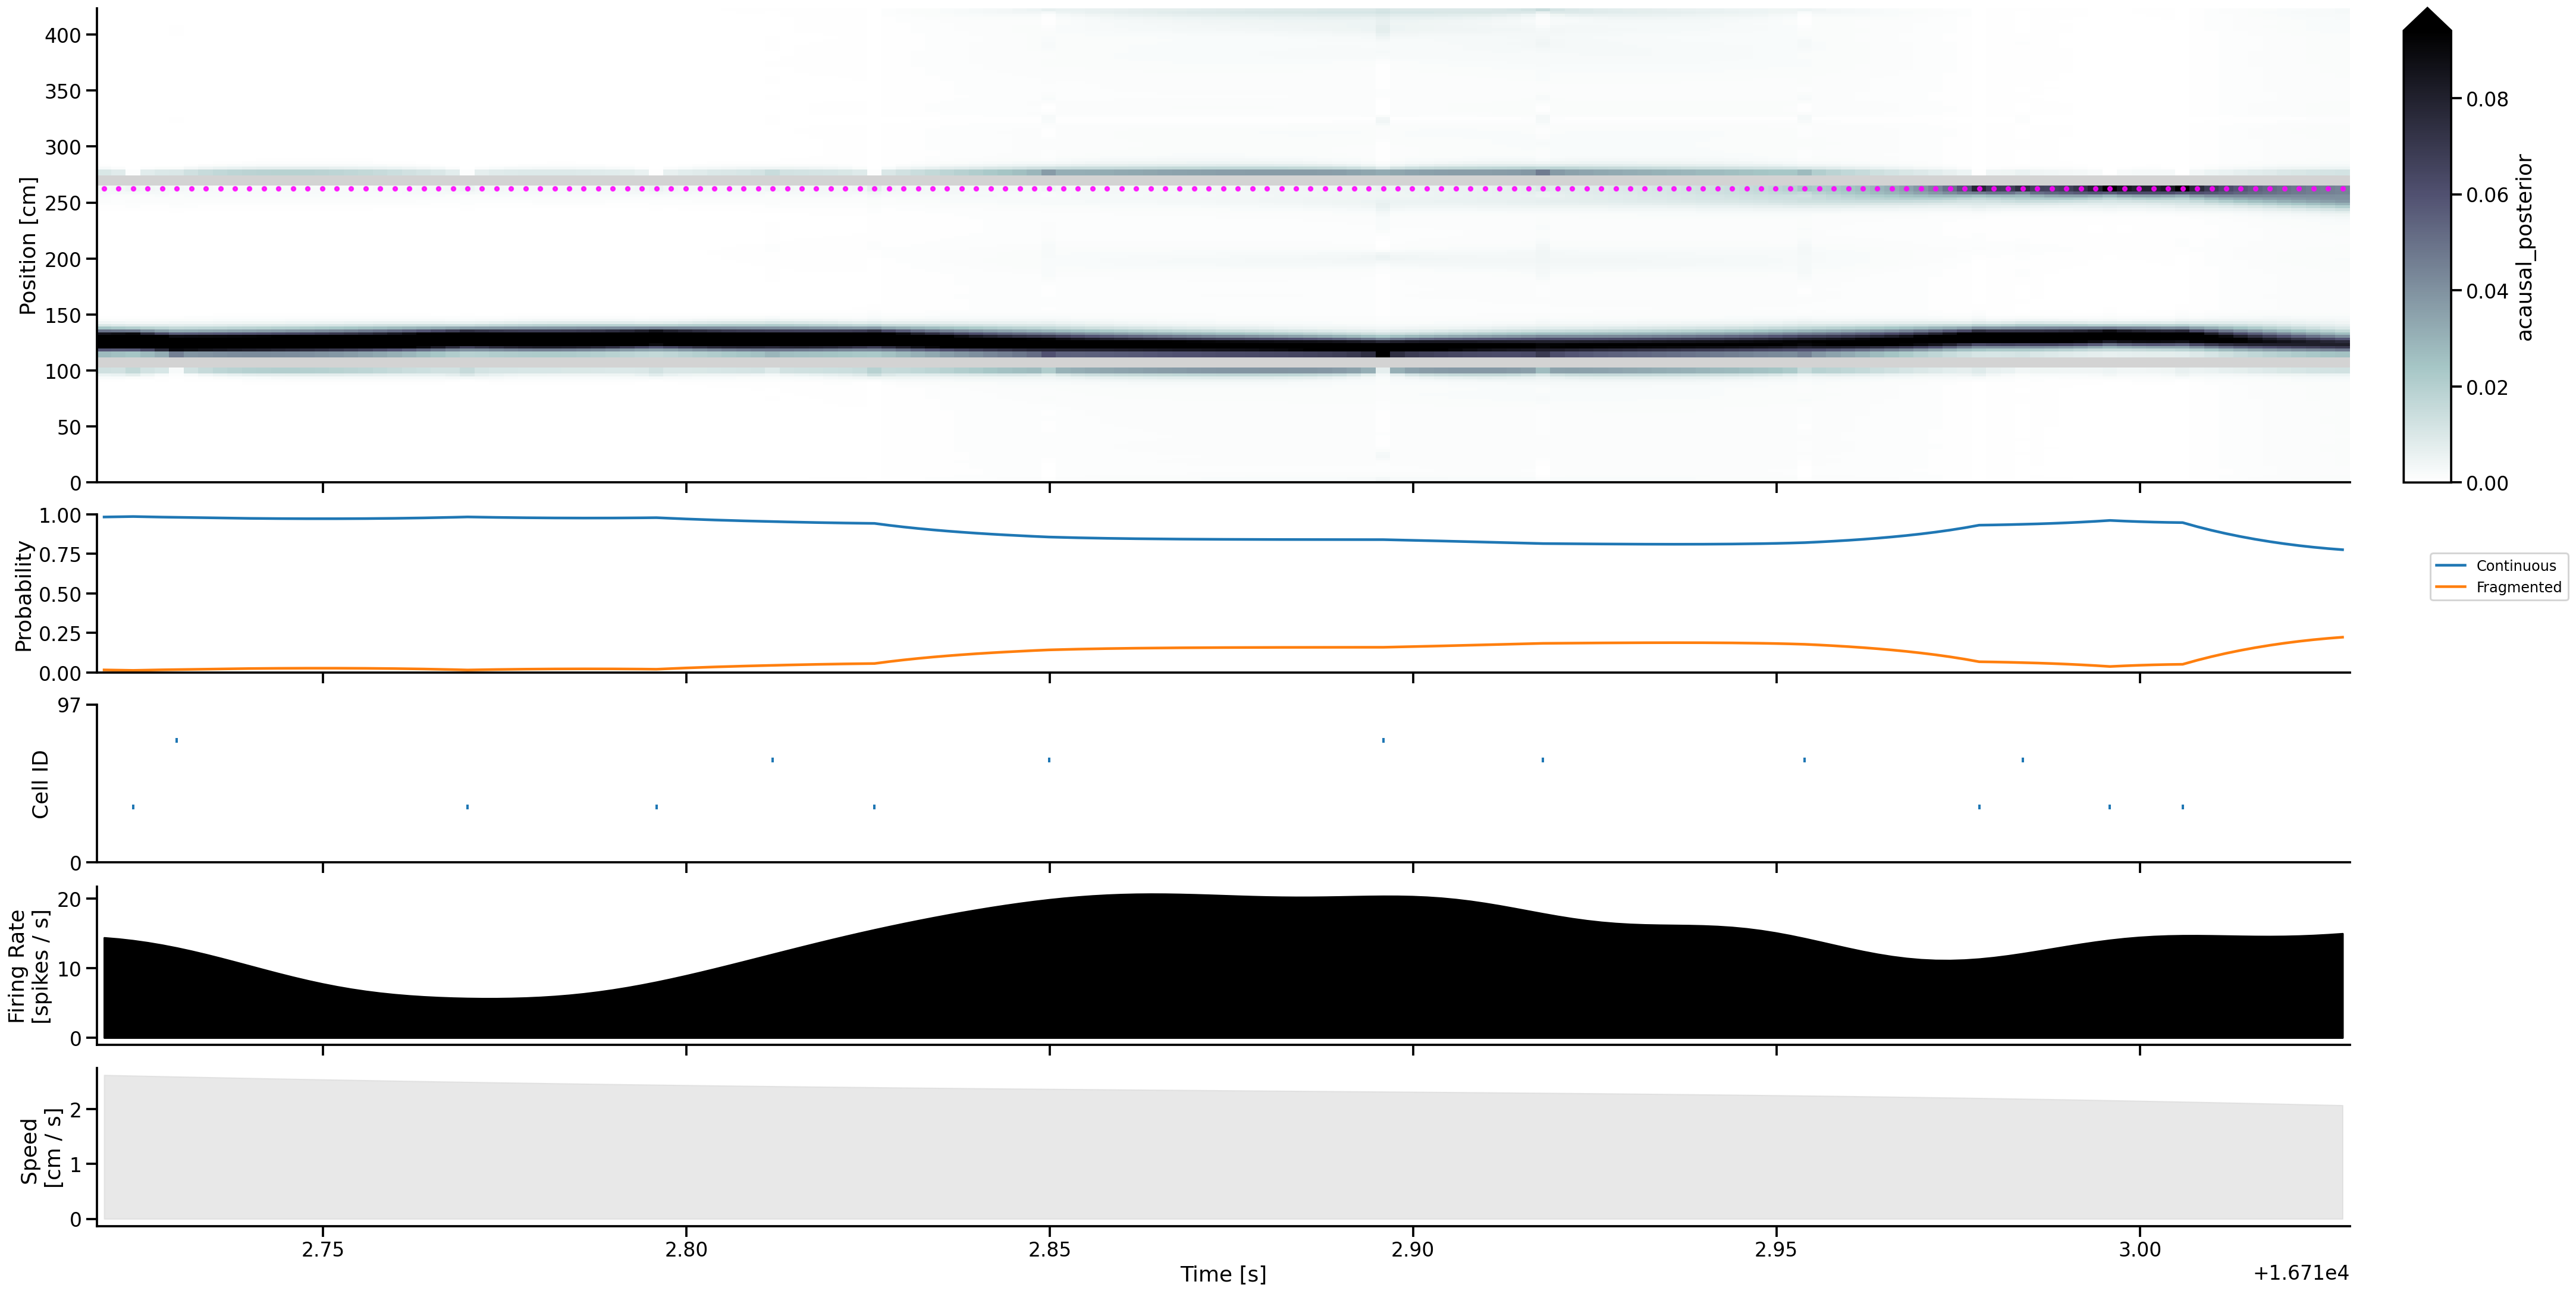

In [22]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(175_495, 175_650)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
    legend=True,
)

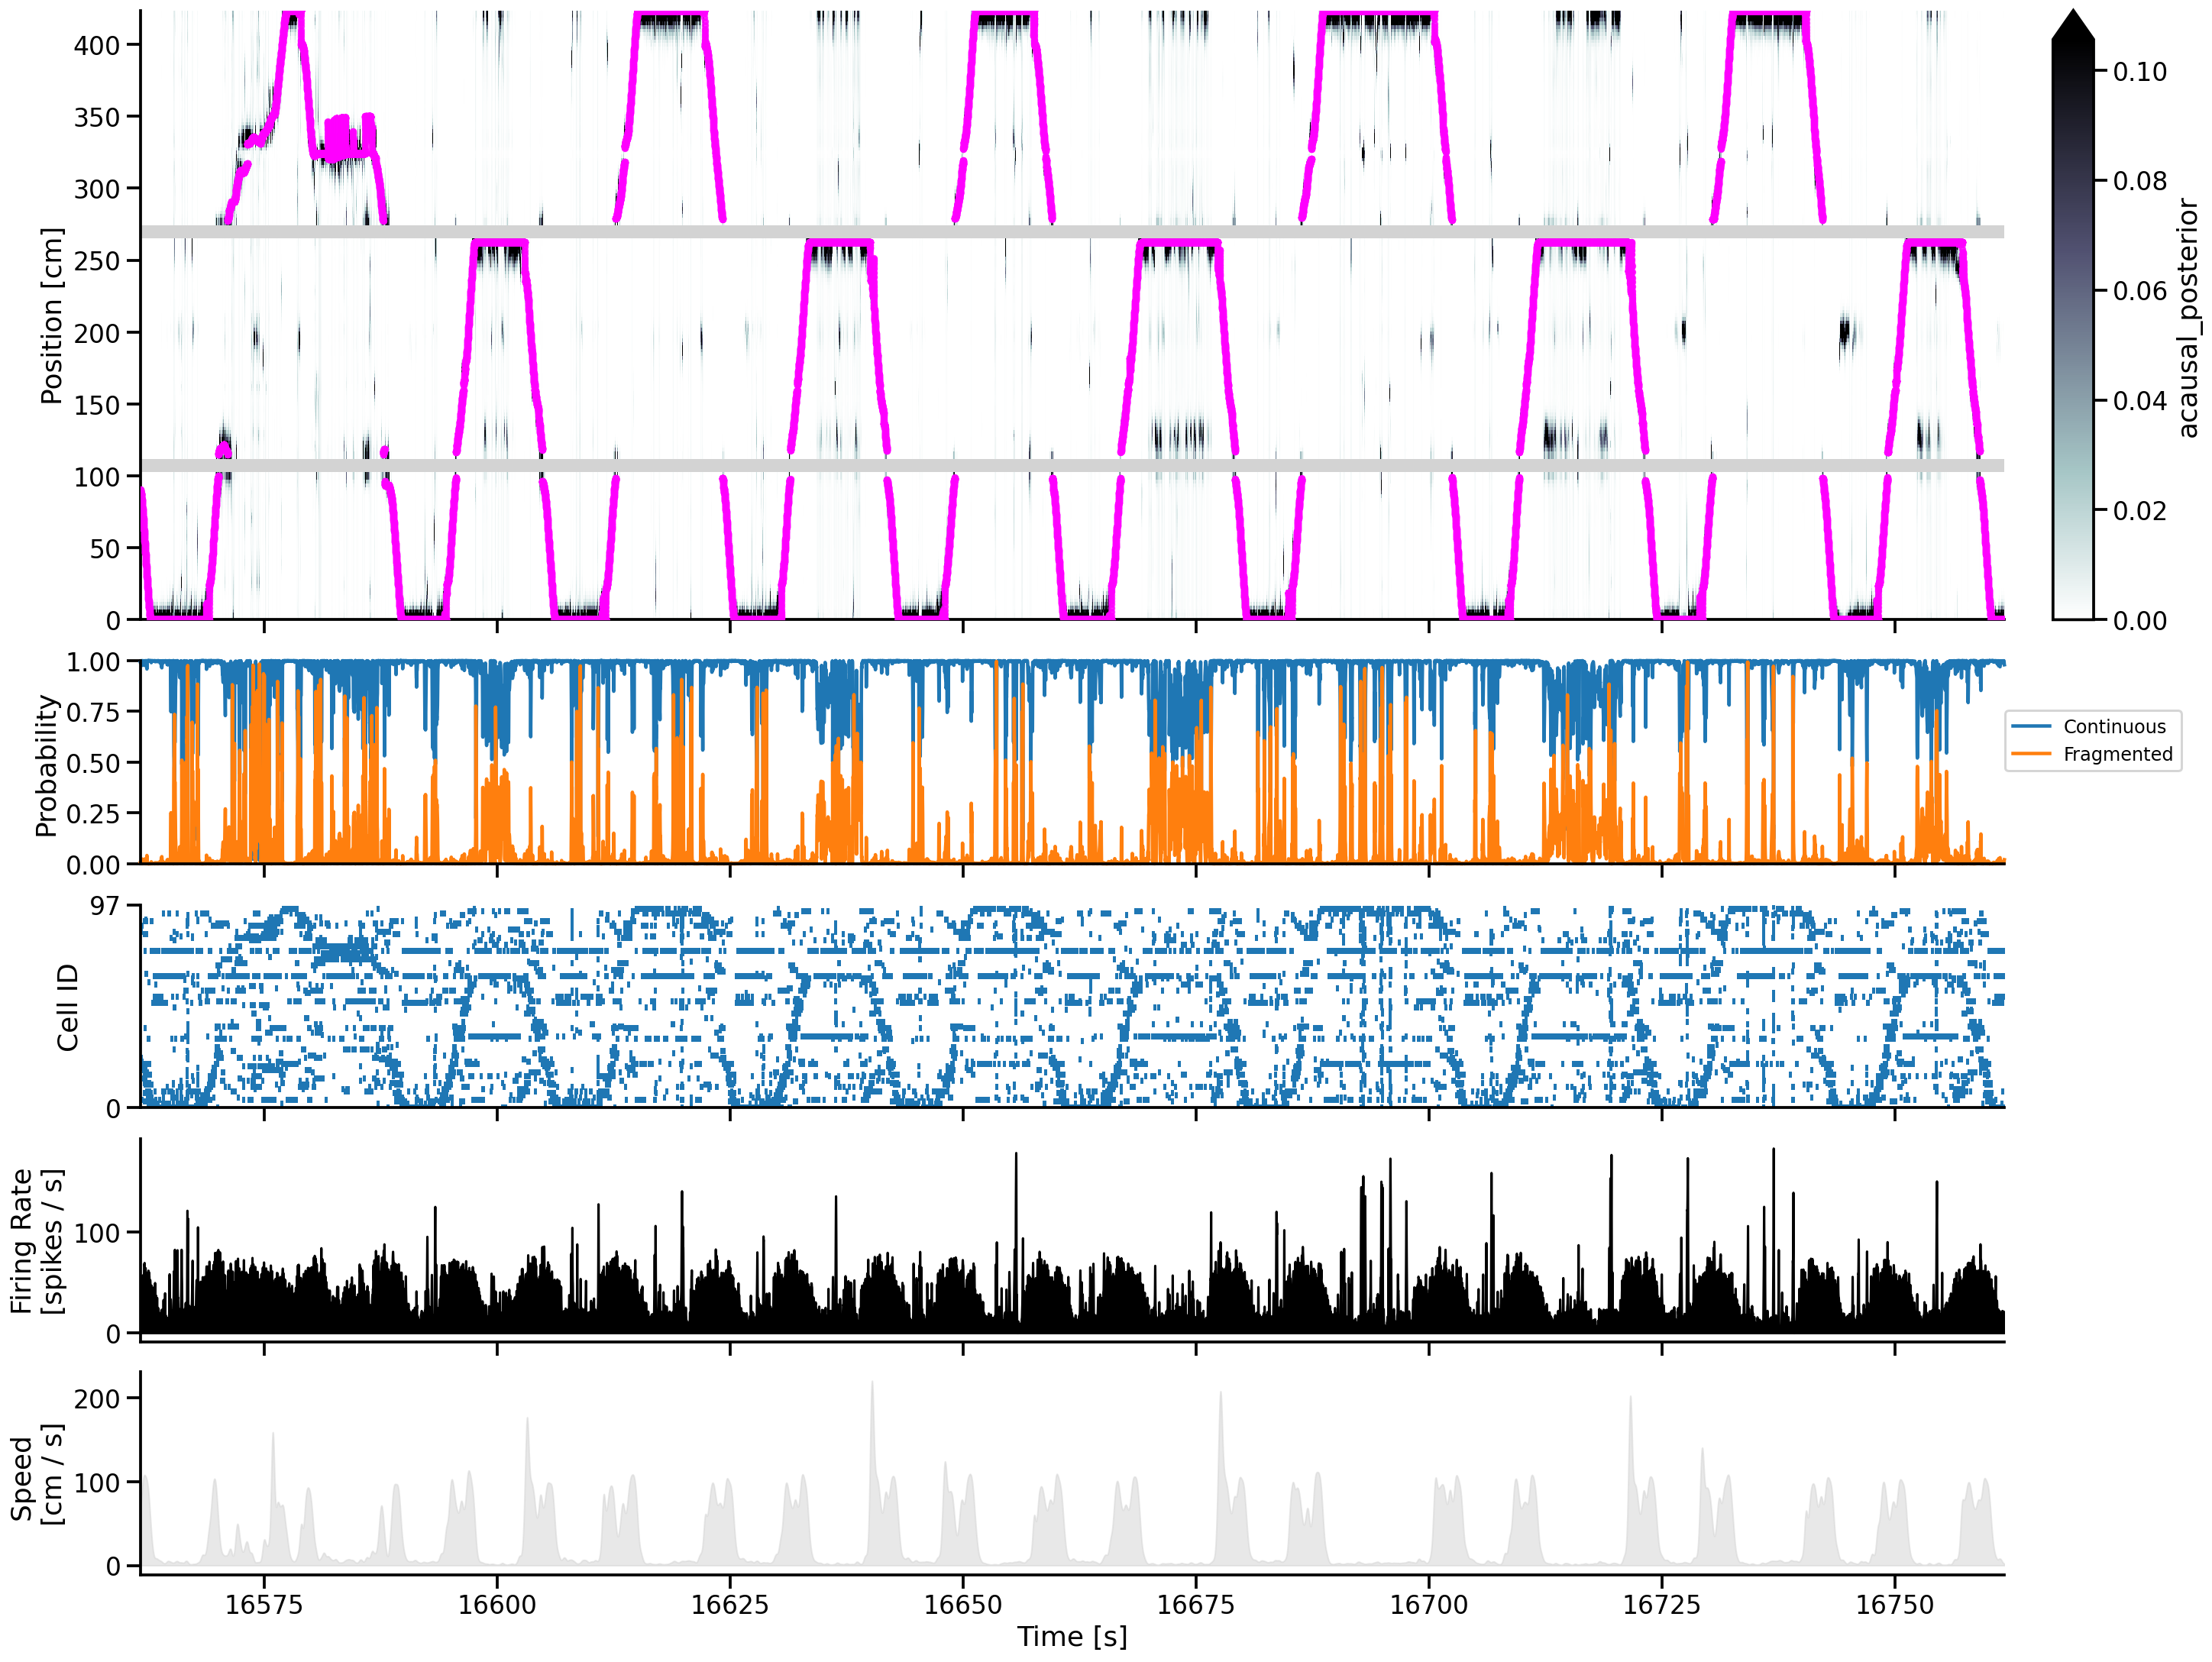

In [23]:
from src.visualization import plot_classifier_spikes

plot_classifier_spikes(
    results.time[slice(100_000, 200_000)],
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(20, 15),
    legend=True,
)

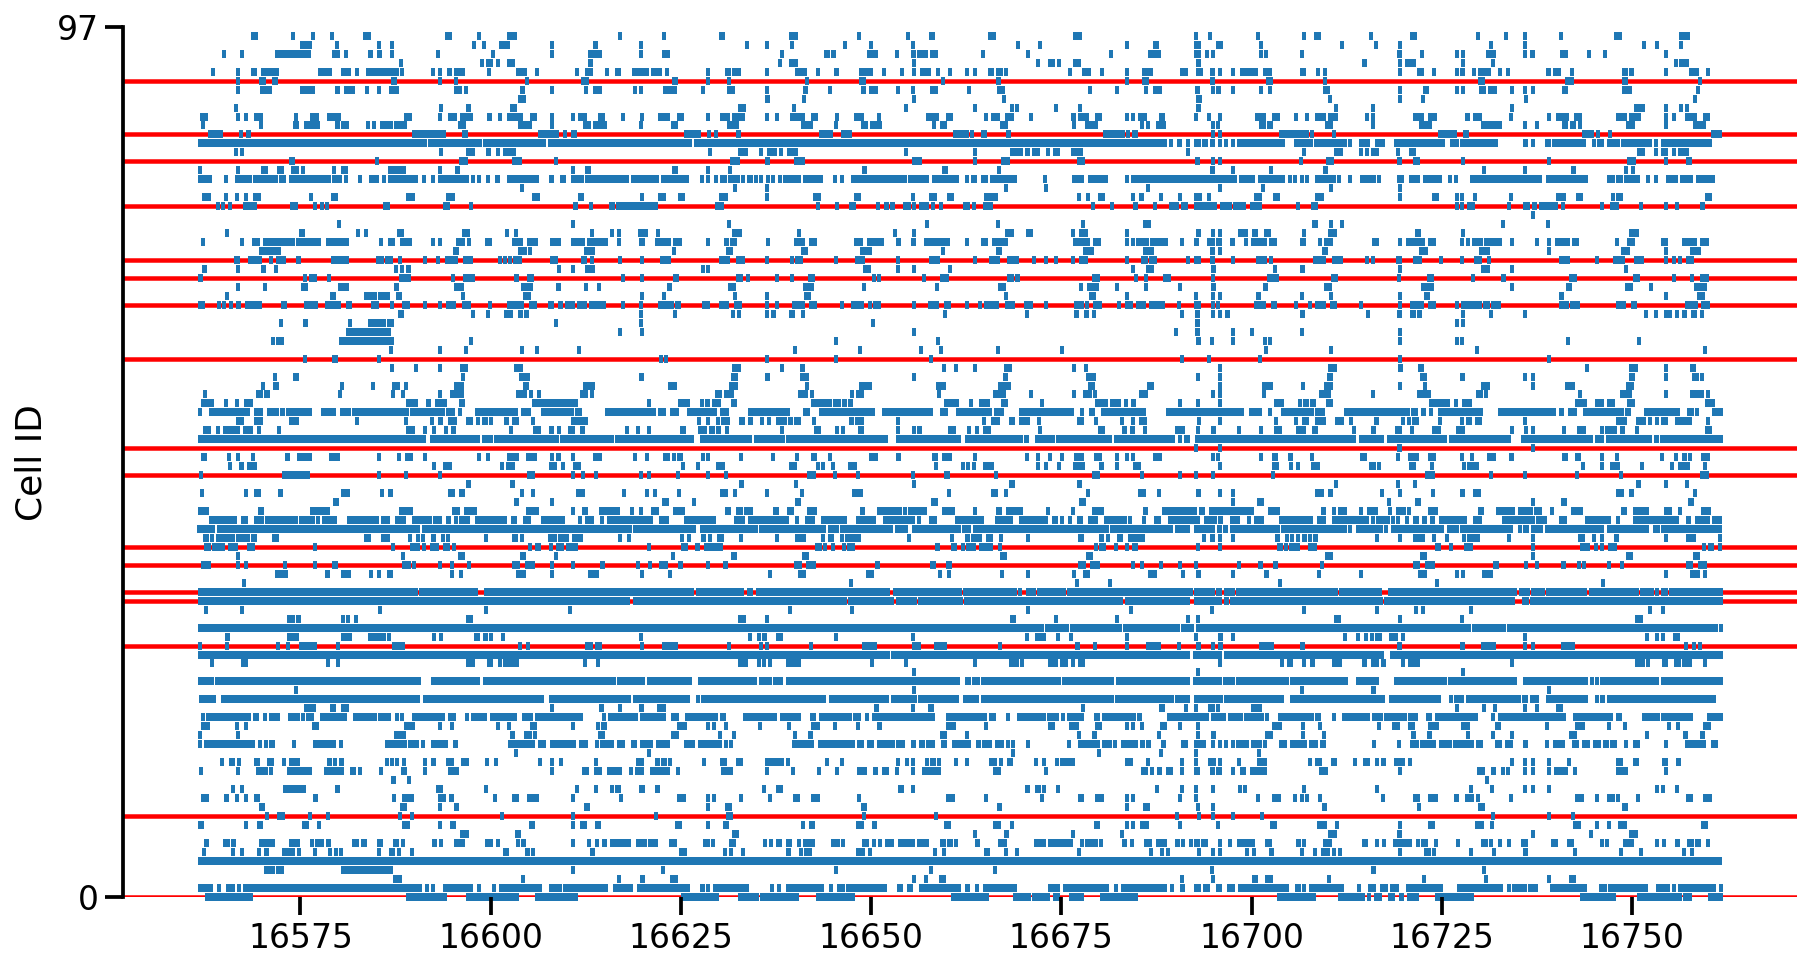

In [114]:
from src.visualization import get_neuron_order

time_slice =  results.time[slice(100_000, 200_000)]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
neuron_order = get_neuron_order(classifier)

spikes = (
    data["spikes"]
    .reset_index(drop=True)
    .set_index(
        data["spikes"].index / np.timedelta64(1, "s"))
)
spikes = spikes.iloc[:, neuron_order.neuron_ind]

spike_time_ind, neuron_ind = np.nonzero(np.asarray(spikes.loc[time_slice]))
spike_times = np.asarray(spikes.loc[time_slice].index)[spike_time_ind]
encoding_group = neuron_order.encoding_group.values[neuron_ind]

for group in np.unique(encoding_group):
    ax.scatter(spike_times[encoding_group == group],
                    neuron_ind[encoding_group == group],
                    zorder=1,
                    marker='|',
                    s=20,
                    linewidth=2, clip_on=False)
n_neurons = spikes.shape[1]
ax.set_yticks((0, n_neurons))
ax.set_ylim((0, n_neurons))
ax.set_ylabel('Cell ID')

blah = np.asarray((data['spikes'].mean() * SAMPLING_FREQUENCY) > 5)
for neuron_ind in np.nonzero(blah.squeeze())[0]:
    ax.axhline(neuron_ind, color='red', zorder=-1)

sns.despine(bottom=True)

In [74]:
np.nonzero(spikes.loc[time_slice].mean().values * 500 > 4)[0]

array([ 0, 63, 75])

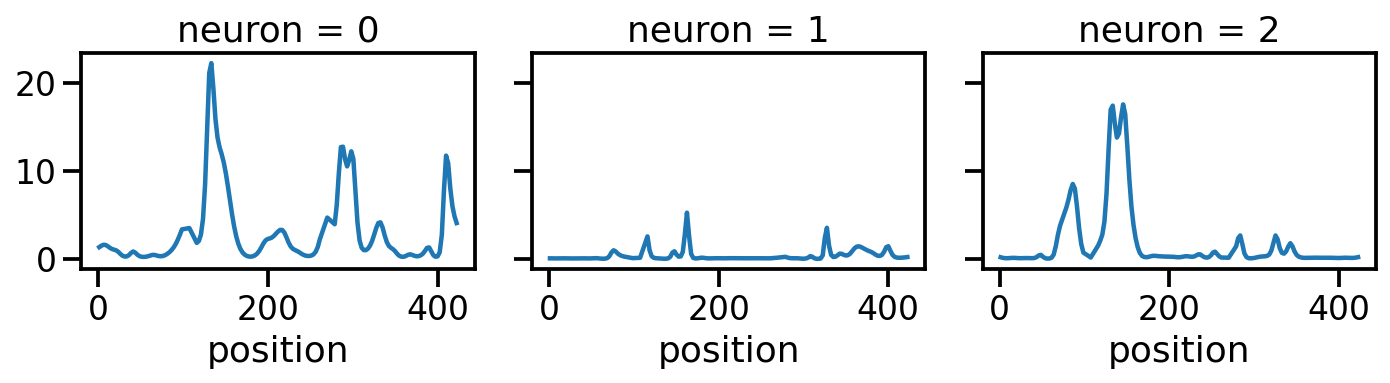

In [67]:
(classifier.place_fields_.isel(neuron=np.nonzero(spikes.loc[time_slice].mean().values * 500 > 4)[0]) * 500).plot(x='position', col='neuron')

In [44]:
spikes.loc[:, spikes.loc[time_slice].mean() * 500 > 4]

,Jaq_03_12_029_033,Jaq_03_12_002_018,Jaq_03_12_011_018
time,,,
16361.729892,1,42,67
16361.731892,0,0,0
16361.733892,0,0,0
16361.735892,0,0,0
16361.737892,0,0,0
...,...,...,...
17265.505892,0,0,0
17265.507892,0,0,0
17265.509892,0,0,0


In [68]:
(data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY) < 5

Jaq_03_12_001_004    True
Jaq_03_12_001_009    True
Jaq_03_12_001_014    True
Jaq_03_12_001_040    True
Jaq_03_12_001_047    True
                     ... 
Jaq_03_12_030_019    True
Jaq_03_12_030_020    True
Jaq_03_12_030_021    True
Jaq_03_12_030_022    True
Jaq_03_12_030_050    True
Length: 97, dtype: bool

In [71]:
(data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY).loc[['Jaq_03_12_029_033', 'Jaq_03_12_002_018', 'Jaq_03_12_011_018']]

Jaq_03_12_029_033    3.126668
Jaq_03_12_002_018    3.927400
Jaq_03_12_011_018    4.357726
dtype: float64

In [72]:
((data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY) < 5).sum()

97

In [77]:
((data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY) < 3.9).sum()

93

In [79]:
data['neuron_info'].loc[('Jaq', 3, 12, 11, 18)]

bursting_parent                                                               0
dur_sec                                                                 909.507
firing_rate                                                              5.6756
isolation                                                               0.98913
noise_overlap                                                        0.00352526
num_events                                                                 5162
overlap_cluster                                                               4
peak_amp                                                                12.3991
peak_noise                                                              2.29991
peak_snr                                                                5.39115
t1_sec                                                                  13055.9
t2_sec                                                                  13965.4
label                                   

In [80]:
data['neuron_info'].loc[('Jaq', 3, 12, 2, 18)]

bursting_parent                                                               0
dur_sec                                                                 909.509
firing_rate                                                             5.12255
isolation                                                              0.996475
noise_overlap                                                         0.0190952
num_events                                                                 4659
overlap_cluster                                                              40
peak_amp                                                                7.69678
peak_noise                                                              1.48265
peak_snr                                                                5.19125
t1_sec                                                                    13056
t2_sec                                                                  13965.5
label                                   

In [81]:
data['neuron_info'].loc[('Jaq', 3, 12, 29, 33)]

bursting_parent                                                               0
dur_sec                                                                  904.22
firing_rate                                                             3.93599
isolation                                                                     1
noise_overlap                                                                 0
num_events                                                                 3559
overlap_cluster                                                               0
peak_amp                                                                16.7759
peak_noise                                                              2.78858
peak_snr                                                                6.01594
t1_sec                                                                    13061
t2_sec                                                                  13965.2
label                                   

In [83]:
(data['neuron_info'].firing_rate > 5).sum()

2

In [86]:
(data['neuron_info'].firing_rate > 4).sum()

25

In [87]:
(data['neuron_info'].firing_rate > 5).sum()

22

In [95]:
np.nonzero([np.asarray(data['neuron_info'].firing_rate > 5)])[1]

array([  0,   9,  28,  33,  34,  37,  39,  47,  50,  60,  66,  69,  71,
        77,  82,  85,  91,  99, 101, 102, 103, 107])

In [89]:
is_pyramidal = np.asarray((data['spikes'].loc[data['position_info'].nose_vel > 4].mean() * SAMPLING_FREQUENCY) < 5)

In [90]:
is_pyramidal.sum()

97

In [92]:
np.asarray(data['neuron_info'].firing_rate < 5).sum()

99